# ⚙️ Damped Dual Mass System: DMD vs Koopman (EDMD)
This notebook simulates a dual-mass system and compares classical DMD with Extended DMD (Koopman) using enhanced polynomial observables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.linalg import svd, pinv, eig

np.random.seed(42)

In [2]:
# System parameters and dynamics
m1, m2 = 1.0, 1.0
k1, k2 = 10.0, 15.0
c = 1.0

def system_dynamics(t, x):
    x1, x2, v1, v2 = x
    F = np.sin(0.5 * t)
    a1 = (-(k1 + k2) * x1 + k2 * x2 - c * (v1 - v2)) / m1
    a2 = (k2 * (x1 - x2) + c * (v1 - v2) + F) / m2
    return [v1, v2, a1, a2]

In [3]:
# Simulate system
t_span = [0, 50]
t_eval = np.linspace(*t_span, 1000)
x0 = [0.1, 0.0, 0.0, 0.0]
sol = solve_ivp(system_dynamics, t_span, x0, t_eval=t_eval)
X = sol.y

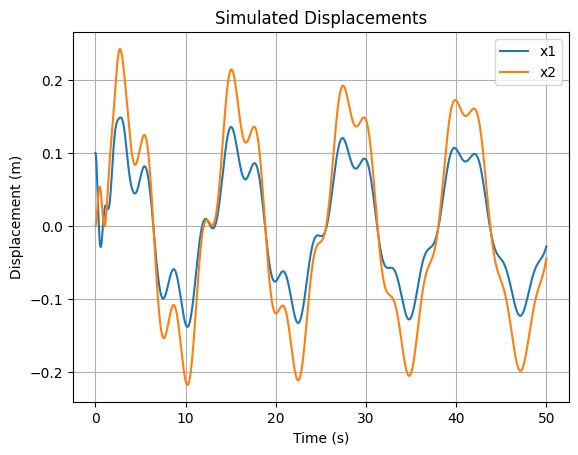

In [4]:
# Plot simulation
plt.plot(t_eval, X[0], label='x1')
plt.plot(t_eval, X[1], label='x2')
plt.title('Simulated Displacements')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
!pip install pydmd


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 6.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.8/3.0 MB 3.7 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/3.0 MB 2.6 MB/s eta 0:00:01
   ------------------------ --------------- 1.8/3.0 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 3.0/3.0 MB 3.7 MB/s eta 0:00:00


In [5]:
# Classical DMD
X1, X2 = X[:, :-1], X[:, 1:]
U, S, Vh = svd(X1, full_matrices=False)
r = 10
Ur, Sr, Vr = U[:, :r], np.diag(S[:r]), Vh.conj().T[:, :r]
A_tilde = Ur.T @ X2 @ Vr @ pinv(Sr)
eigvals, W = eig(A_tilde)
Phi = X2 @ Vr @ pinv(Sr) @ W
b = pinv(Phi) @ X[:, 0]
omega = np.log(eigvals)
time_dynamics = np.array([b * np.exp(omega * t) for t in t_eval]).T
X_dmd = Phi @ time_dynamics

C:\Users\mlesan4\AppData\Local\Temp\ipykernel_40380\114199207.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred[:, idx] = y


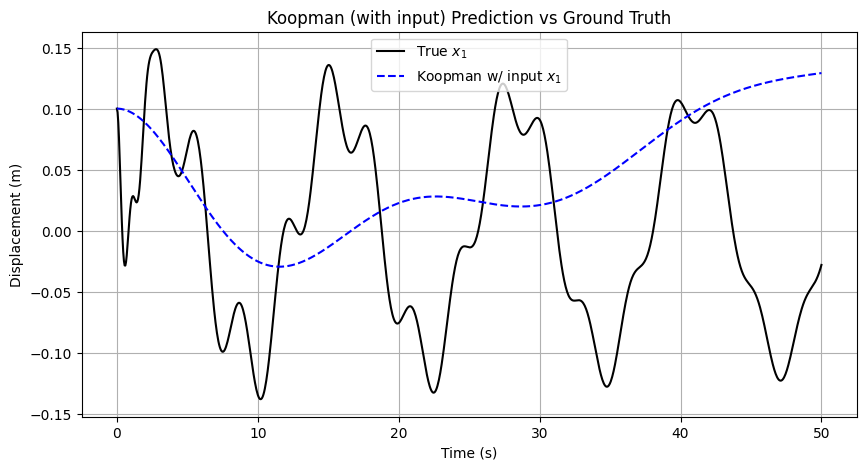

EDMD w/ input relative error: 1.2891
Koopman eigenvalue magnitudes: [0.91459457 0.91459457 0.95714109 0.95714109 0.93401203 0.93401203
 0.99255221 0.99255221 0.99817738 0.99817738 0.94409184 0.94409184
 0.99684754 0.99684754 0.9817622 ]


In [16]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from numpy.linalg import svd, pinv, eig

# System parameters
m1, m2 = 1.0, 1.0
k1, k2 = 10.0, 15.0
c   = 1.0

def F(t):
    return np.sin(0.5 * t)

def dynamics(t, x):
    x1, x2, v1, v2 = x
    a1 = (-(k1 + k2)*x1 + k2*x2 - c*(v1 - v2)) / m1
    a2 = ( k2*(x1 - x2) + c*(v1 - v2) + F(t) ) / m2
    return [v1, v2, a1, a2]

# --- Observable lift including the input F(t) ---
def lift(x, u):
    x1, x2, v1, v2 = x
    return np.array([
        x1, x2, v1, v2,
        u,              # include the forcing itself
        x1**2, x2**2, v1**2, v2**2,
        x1*x2, v1*v2,
        x1*u, x2*u, v1*u, v2*u
    ])

# Simulation settings
t_total = np.linspace(0, 50, 1001)
x0 = [0.1, 0.0, 0.0, 0.0]
sol = spi.solve_ivp(dynamics, [0,50], x0, t_eval=t_total)
X = sol.y  # (4, len)

# --- Build EDMD with input on first 20s ---
mask = t_total <= 20
t_train = t_total[mask]
X_train = X[:, mask]

# Build lifted snapshot matrices Ψ1 and Ψ2, and input vector u
Psi1, Psi2 = [], []
U_train = F(t_train)
for i, t in enumerate(t_train[:-1]):
    Psi1.append(lift(X_train[:,i], U_train[i]))
    Psi2.append(lift(X_train[:,i+1], U_train[i+1]))
Psi1 = np.array(Psi1).T   # shape (d, n-1)
Psi2 = np.array(Psi2).T

# EDMD: K ≈ Ψ2 Ψ1^+  via SVD truncation
U, S, Vh = svd(Psi1, full_matrices=False)
r = 20
Ur, Sr, Vr = U[:,:r], np.diag(S[:r]), Vh.conj().T[:,:r]
K_tilde = Ur.T @ Psi2 @ Vr @ pinv(Sr)
eigvals, W = eig(K_tilde)
Phi = Psi2 @ Vr @ pinv(Sr) @ W

# Initial lifted state
y0 = lift(X_train[:,0], U_train[0])
b = pinv(Phi) @ y0

# --- Predict over full 50s ---
omega = np.log(eigvals)
Y_pred = np.zeros((Phi.shape[0], len(t_total)))
for idx, t in enumerate(t_total):
    u = F(t)
    # time evolution of Koopman modes
    dyn = b * np.exp(omega * t)
    # reconstruct in lifted space
    y = Phi @ dyn
    Y_pred[:, idx] = y

# Extract predicted x1
x1_edmd = Y_pred[0]

# Plot
plt.figure(figsize=(10,5))
plt.plot(t_total, X[0],  'k',    label='True $x_1$')
plt.plot(t_total, x1_edmd,'b--', label='Koopman w/ input $x_1$')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Koopman (with input) Prediction vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

# Compute relative error
err = np.linalg.norm(X[0] - x1_edmd) / np.linalg.norm(X[0])
print(f"EDMD w/ input relative error: {err:.4f}")
print("Koopman eigenvalue magnitudes:", np.abs(eigvals))


C:\Users\mlesan4\AppData\Local\Temp\ipykernel_40380\549690366.py:79: RuntimeWarning: divide by zero encountered in log
  dyn = b * np.exp(np.log(eigvals)*t)
C:\Users\mlesan4\AppData\Local\Temp\ipykernel_40380\549690366.py:79: RuntimeWarning: invalid value encountered in multiply
  dyn = b * np.exp(np.log(eigvals)*t)
C:\Users\mlesan4\AppData\Local\Temp\ipykernel_40380\549690366.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred[:, idx] = y


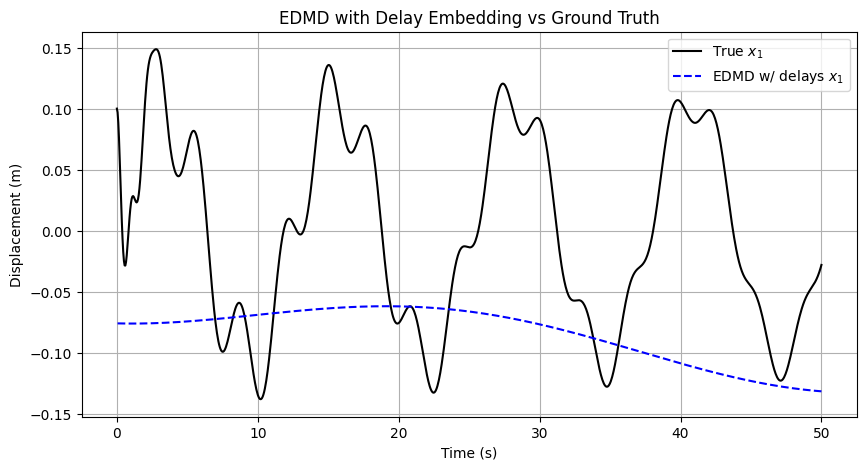

Relative error: nan
Eigenvalue magnitudes: [0.         0.         0.48797141 0.79977725 0.79977725 0.80544812
 0.80544812 0.64503704 0.64503704 0.49338447 0.49338447 0.06230254
 0.066985   0.066985   0.81461894 0.81461894 0.90671226 0.90671226
 0.95640768 0.95640768 0.95437337 0.95437337 0.95204759 0.95204759
 0.92552506 0.92552506 0.66775765 0.73782804 0.73782804 0.99361755
 0.99361755 0.95585374 0.95585374 0.99873018 0.99873018 0.9952063
 0.9952063  0.9068386  0.99780145 0.99780145 1.         1.
 0.98951311 0.98951311]


In [18]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from numpy.linalg import svd, pinv, eig

# System parameters
m1, m2 = 1.0, 1.0
k1, k2 = 10.0, 15.0
c    = 1.0

def F(t):
    return np.sin(0.5 * t)

def dynamics(t, x):
    x1, x2, v1, v2 = x
    a1 = (-(k1+k2)*x1 + k2*x2 - c*(v1-v2)) / m1
    a2 = ( k2*(x1-x2) + c*(v1-v2) + F(t)) / m2
    return [v1, v2, a1, a2]

# --- Delay-embedding lift ---
def lift_with_delays(history, delays):
    """
    history: list of (x, u) pairs from t-k*dt to t
    delays: number of past steps (including current)
    """
    obs = []
    for (x,u) in history:
        x1,x2,v1,v2 = x
        # basic polynomial observables
        obs.extend([x1, x2, v1, v2, u,
                    x1**2, x2**2, v1**2, v2**2,
                    x1*x2, v1*v2])
    return np.array(obs)

# Simulation
t_total = np.linspace(0,50,1001)
sol = spi.solve_ivp(dynamics, [0,50], [0.1,0,0,0], t_eval=t_total)
X = sol.y  # (4, len)

# Training on first 20s
mask = t_total <= 20
t_train = t_total[mask]
X_train = X[:,mask]
U_train = F(t_train)

# Build delay-embedded snapshots
D = 3   # number of delays
dt = t_train[1]-t_train[0]

Psi1, Psi2 = [], []
for i in range(D, len(t_train)-1):
    # collect history of length D+1 up to time index i
    hist1 = [(X_train[:, j], U_train[j]) for j in range(i-D, i+1)]
    hist2 = [(X_train[:, j], U_train[j]) for j in range(i-D+1, i+2)]
    Psi1.append(lift_with_delays(hist1, D+1))
    Psi2.append(lift_with_delays(hist2, D+1))

Psi1 = np.array(Psi1).T
Psi2 = np.array(Psi2).T

# EDMD via truncated SVD
U_s, S_s, Vh_s = svd(Psi1, full_matrices=False)
r = 50
Ur, Sr, Vr = U_s[:,:r], np.diag(S_s[:r]), Vh_s.conj().T[:,:r]
K_tilde = Ur.T @ Psi2 @ Vr @ pinv(Sr)
eigvals, W = eig(K_tilde)
Phi = Psi2 @ Vr @ pinv(Sr) @ W

# Initial lifted state
# use last D+1 history at training cutoff
hist0 = [(X_train[:, j], U_train[j]) for j in range(len(t_train)-D-1, len(t_train))]
y0 = lift_with_delays(hist0, D+1)
b = pinv(Phi) @ y0

# Predict over full 50s
Y_pred = np.zeros((Phi.shape[0], len(t_total)))
for idx,t in enumerate(t_total):
    u = F(t)
    dyn = b * np.exp(np.log(eigvals)*t)
    y = Phi @ dyn
    Y_pred[:, idx] = y

x1_edmd = Y_pred[0]  # first entry corresponds to x1(t)

# Plot
plt.figure(figsize=(10,5))
plt.plot(t_total, X[0], 'k',    label='True $x_1$')
plt.plot(t_total, x1_edmd,  'b--', label='EDMD w/ delays $x_1$')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('EDMD with Delay Embedding vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

# Error
err = np.linalg.norm(X[0]-x1_edmd)/np.linalg.norm(X[0])
print(f"Relative error: {err:.4f}")
print("Eigenvalue magnitudes:", np.abs(eigvals))


In [19]:
!pip install git+https://github.com/CU-Denver-MathStats-OER/ODEs
from IPython.display import clear_output
clear_output()

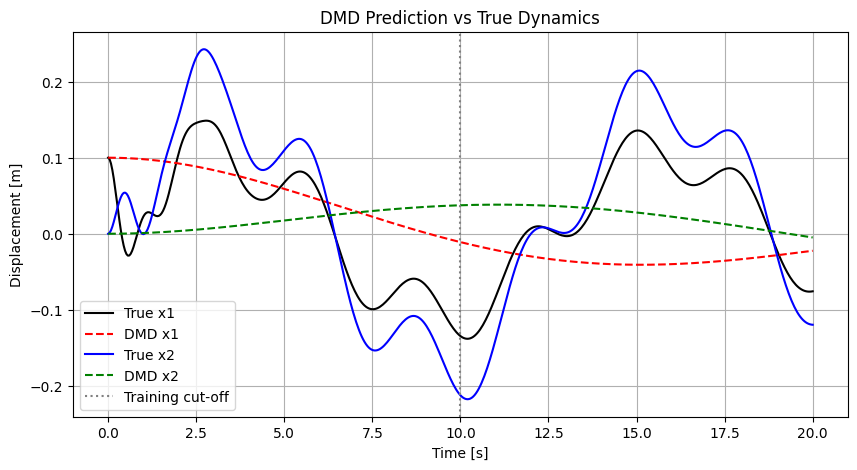

Relative error x1: 1.0597
Relative error x2: 1.0241


In [22]:

import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from numpy.linalg import svd, pinv, eig, norm

# System parameters
m1, m2 = 1.0, 1.0
k1, k2 = 10.0, 15.0
c    = 1.0

def F(t):
    return np.sin(0.5 * t)

def dynamics(t, x):
    x1, x2, v1, v2 = x
    a1 = (-(k1+k2)*x1 + k2*x2 - c*(v1-v2)) / m1
    a2 = ( k2*(x1-x2) + c*(v1-v2) + F(t)) / m2
    return [v1, v2, a1, a2]

def compute_dmd(X, Y, r):
    # X, Y: data matrices (n x m)
    U, S, Vh = svd(X, full_matrices=False)
    Ur = U[:, :r]
    Sr = np.diag(S[:r])
    Vr = Vh.conj().T[:, :r]
    A_tilde = Ur.T @ Y @ Vr @ pinv(Sr)
    eigvals, W = eig(A_tilde)
    Phi = Y @ Vr @ pinv(Sr) @ W
    return eigvals, Phi

def dmd_predict(eigvals, Phi, x0, t):
    # x0: initial state vector, t: time vector
    b = pinv(Phi) @ x0
    omega = np.log(eigvals)
    X_dmd = np.zeros((Phi.shape[0], len(t)), dtype=complex)
    for i, ti in enumerate(t):
        X_dmd[:, i] = Phi @ (b * np.exp(omega * ti))
    return X_dmd

def main():
    # Time settings
    t_start, t_stop, t_train = 0.0, 20.0, 10.0
    ncp = 500
    t = np.linspace(t_start, t_stop, ncp+1)
    dt = t[1] - t[0]
    
    # Simulate system
    x0 = [0.1, 0.0, 0.0, 0.0]
    sol = spi.solve_ivp(dynamics, [t_start, t_stop], x0, t_eval=t)
    X = sol.y  # shape (4, ncp+1)
    
    # Split into training (first t_train seconds) and full
    train_mask = t <= t_train
    X_train = X[:, train_mask]
    
    # Build DMD matrices
    X1 = X_train[:, :-1]
    X2 = X_train[:, 1:]
    
    # Compute DMD
    r = 10  # truncation rank
    eigvals, Phi = compute_dmd(X1, X2, r)
    
    # Predict over full time
    X_dmd = dmd_predict(eigvals, Phi, X_train[:, 0], t)
    
    # Plot true vs DMD for x1 and x2
    plt.figure(figsize=(10,5))
    plt.plot(t, X[0], 'k', label='True x1')
    plt.plot(t, X_dmd[0].real, 'r--', label='DMD x1')
    plt.plot(t, X[1], 'b', label='True x2')
    plt.plot(t, X_dmd[1].real, 'g--', label='DMD x2')
    plt.axvline(x=t_train, color='gray', linestyle=':', label='Training cut-off')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacement [m]')
    plt.title('DMD Prediction vs True Dynamics')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute and print errors
    err_x1 = norm(X[0] - X_dmd[0].real) / norm(X[0])
    err_x2 = norm(X[1] - X_dmd[1].real) / norm(X[1])
    print(f'Relative error x1: {err_x1:.4f}')
    print(f'Relative error x2: {err_x2:.4f}')

if __name__ == '__main__':
    main()


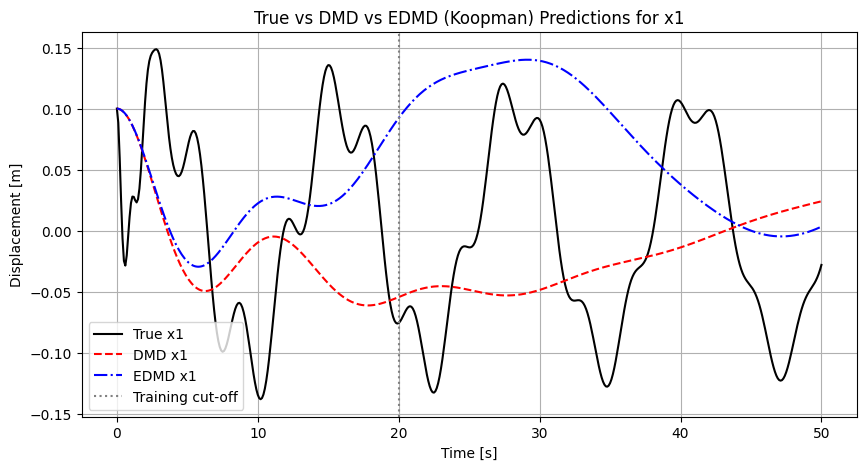

Relative error DMD x1: 1.1316
Relative error EDMD x1: 1.4067


In [24]:

import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from numpy.linalg import svd, pinv, eig, norm

# System parameters
m1, m2 = 1.0, 1.0
k1, k2 = 10.0, 15.0
c    = 1.0

def F(t):
    return np.sin(0.5 * t)

def dynamics(t, x):
    x1, x2, v1, v2 = x
    a1 = (-(k1+k2)*x1 + k2*x2 - c*(v1-v2)) / m1
    a2 = ( k2*(x1-x2) + c*(v1-v2) + F(t)) / m2
    return [v1, v2, a1, a2]

def compute_dmd(X, Y, r):
    U, S, Vh = svd(X, full_matrices=False)
    Ur, Sr, Vr = U[:, :r], np.diag(S[:r]), Vh.conj().T[:, :r]
    A_tilde = Ur.T @ Y @ Vr @ pinv(Sr)
    eigvals, W = eig(A_tilde)
    Phi = Y @ Vr @ pinv(Sr) @ W
    return eigvals, Phi

def dmd_predict(eigvals, Phi, x0, t):
    b = pinv(Phi) @ x0
    omega = np.log(eigvals)
    X_dmd = np.zeros((Phi.shape[0], len(t)), dtype=complex)
    for i, ti in enumerate(t):
        X_dmd[:, i] = Phi @ (b * np.exp(omega * ti))
    return X_dmd

def lift(x, u):
    x1, x2, v1, v2 = x
    return np.array([
        x1, x2, v1, v2, u,
        x1**2, x2**2, v1**2, v2**2,
        x1*x2, v1*v2, x1*u, x2*u, v1*u, v2*u
    ])

def compute_edmd(X, t, t_train, r):
    # Determine training length
    m_train = np.sum(t <= t_train)
    # Build lifted snapshots
    Psi1, Psi2 = [], []
    for i in range(m_train-1):
        xk = X[:, i]
        xk1 = X[:, i+1]
        uk = F(t[i])
        uk1 = F(t[i+1])
        Psi1.append(lift(xk, uk))
        Psi2.append(lift(xk1, uk1))
    Psi1 = np.column_stack(Psi1)
    Psi2 = np.column_stack(Psi2)
    # EDMD via SVD
    U, S, Vh = svd(Psi1, full_matrices=False)
    Ur, Sr, Vr = U[:, :r], np.diag(S[:r]), Vh.conj().T[:, :r]
    K_tilde = Ur.T @ Psi2 @ Vr @ pinv(Sr)
    eigvals, W = eig(K_tilde)
    Phi = Psi2 @ Vr @ pinv(Sr) @ W
    # initial lifted state
    y0 = lift(X[:, 0], F(t[0]))
    return eigvals, Phi, y0

def edmd_predict(eigvals, Phi, y0, t):
    b = pinv(Phi) @ y0
    omega = np.log(eigvals)
    Y_edmd = np.zeros((Phi.shape[0], len(t)), dtype=complex)
    for i, ti in enumerate(t):
        Y_edmd[:, i] = Phi @ (b * np.exp(omega * ti))
    return Y_edmd

def main():
    # Time settings
    t_start, t_stop, t_train = 0.0, 50.0, 20.0
    ncp = 500
    t = np.linspace(t_start, t_stop, ncp+1)

    # Simulate system
    x0 = [0.1, 0.0, 0.0, 0.0]
    sol = spi.solve_ivp(dynamics, [t_start, t_stop], x0, t_eval=t)
    X = sol.y  # (4, ncp+1)

    # --- DMD on first t_train seconds ---
    train_mask = t <= t_train
    X_train = X[:, train_mask]
    X1, X2 = X_train[:, :-1], X_train[:, 1:]
    r_dmd = 10
    eig_dmd, Phi_dmd = compute_dmd(X1, X2, r_dmd)
    X_dmd = dmd_predict(eig_dmd, Phi_dmd, X_train[:,0], t)

    # --- EDMD (Koopman) with input ---
    r_edmd = 15
    eig_edmd, Phi_edmd, y0 = compute_edmd(X, t, t_train, r_edmd)
    Y_edmd = edmd_predict(eig_edmd, Phi_edmd, y0, t)

    # Plot comparisons for x1
    plt.figure(figsize=(10,5))
    plt.plot(t, X[0], 'k', label='True x1')
    plt.plot(t, X_dmd[0].real, 'r--', label='DMD x1')
    plt.plot(t, Y_edmd[0].real, 'b-.', label='EDMD x1')
    plt.axvline(x=t_train, color='gray', linestyle=':', label='Training cut-off')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacement [m]')
    plt.title('True vs DMD vs EDMD (Koopman) Predictions for x1')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Error metrics
    err_dmd = norm(X[0] - X_dmd[0].real) / norm(X[0])
    err_edmd = norm(X[0] - Y_edmd[0].real) / norm(X[0])
    print(f"Relative error DMD x1: {err_dmd:.4f}")
    print(f"Relative error EDMD x1: {err_edmd:.4f}")

if __name__ == '__main__':
    main()


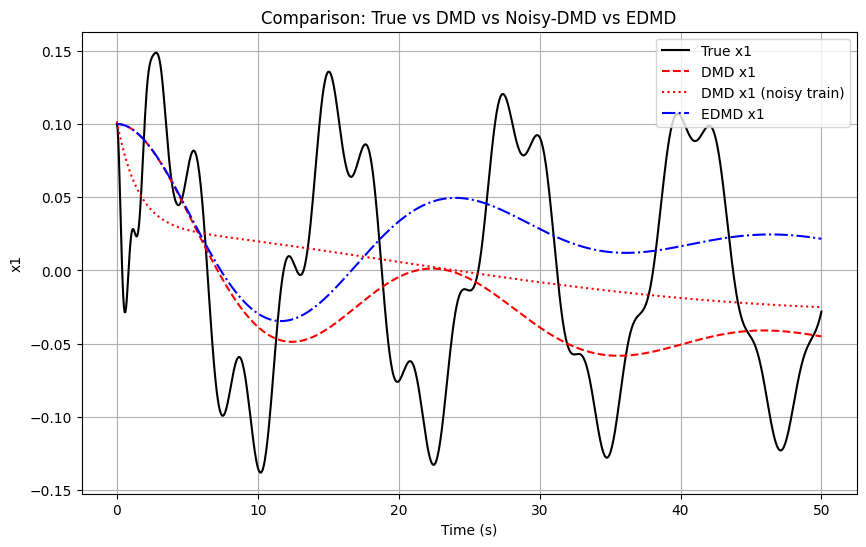

DMD error: 1.0390
DMD (noisy) error: 0.9880
EDMD error: 1.0335
DMD eigenvalues magnitudes: [0.99874769 0.99874769 0.95347238 0.95347238]
EDMD eigenvalues magnitudes: [0.93615868 0.93615868 0.91107218 0.91107218 0.96508314 0.96508314
 0.99772299 0.99772299 0.99764934 0.97362718]


In [13]:

import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from numpy.linalg import svd, pinv, eig

# System parameters
m1, m2 = 1.0, 1.0
k1, k2 = 10.0, 15.0
c = 1.0

def F(t):
    # External force on mass m2
    return np.sin(0.5 * t)

def dynamics(t, x):
    x1, x2, v1, v2 = x
    a1 = (-(k1 + k2)*x1 + k2*x2 - c*(v1 - v2)) / m1
    a2 = ( k2*(x1 - x2) + c*(v1 - v2) + F(t) ) / m2
    return [v1, v2, a1, a2]

# Simulation
t_total = np.linspace(0, 50, 1001)
x0 = [0.1, 0.0, 0.0, 0.0]
sol = spi.solve_ivp(dynamics, [0, 50], x0, t_eval=t_total)
X = sol.y  # shape (4, len(t_total))

# Task 1: DMD on first 20 seconds
t_train_mask = t_total <= 20
t_train = t_total[t_train_mask]
X_train = X[:, t_train_mask]

# Build DMD
X1, X2 = X_train[:, :-1], X_train[:, 1:]
U, S, Vh = svd(X1, full_matrices=False)
r_dmd = 10
Ur, Sr, Vr = U[:, :r_dmd], np.diag(S[:r_dmd]), Vh.conj().T[:, :r_dmd]
A_tilde = Ur.T @ X2 @ Vr @ pinv(Sr)
eig_d, Wd = eig(A_tilde)
Phi_d = X2 @ Vr @ pinv(Sr) @ Wd
b_d = pinv(Phi_d) @ X_train[:, 0]

# Predict full 50s
omega_d = np.log(eig_d)
time_dynamics_d = np.array([b_d * np.exp(omega_d * t) for t in t_total]).T
X_dmd = Phi_d @ time_dynamics_d

# Add noise to training data and re-run DMD
noise_level = 0.01
X_train_noisy = X_train + noise_level * np.random.randn(*X_train.shape)
X1n, X2n = X_train_noisy[:, :-1], X_train_noisy[:, 1:]
U_n, S_n, Vh_n = svd(X1n, full_matrices=False)
Urn, Srn, Vrn = U_n[:, :r_dmd], np.diag(S_n[:r_dmd]), Vh_n.conj().T[:, :r_dmd]
A_tilde_n = Urn.T @ X2n @ Vrn @ pinv(Srn)
eig_dn, Wdn = eig(A_tilde_n)
Phi_dn = X2n @ Vrn @ pinv(Srn) @ Wdn
b_dn = pinv(Phi_dn) @ X_train_noisy[:, 0]
omega_dn = np.log(eig_dn)
time_dynamics_dn = np.array([b_dn * np.exp(omega_dn * t) for t in t_total]).T
X_dmd_noisy = Phi_dn @ time_dynamics_dn

# Task 2: EDMD (Koopman) with polynomial observables
def lift(x):
    x1, x2, v1, v2 = x
    return np.array([x1, x2,
                     v1, v2,
                     x1**2, x2**2, v1**2, v2**2,
                     x1*x2, v1*v2])

# Build lifted data for training (20s)
Y = np.vstack([lift(X_train[:, i]) for i in range(X_train.shape[1])]).T
Y1, Y2 = Y[:, :-1], Y[:, 1:]
Ue, Se, Vhe = svd(Y1, full_matrices=False)
r_edmd = 15
Ure, Sre, Vre = Ue[:, :r_edmd], np.diag(Se[:r_edmd]), Vhe.conj().T[:, :r_edmd]
A_edmd = Ure.T @ Y2 @ Vre @ pinv(Sre)
eig_e, We = eig(A_edmd)
Phi_e = Y2 @ Vre @ pinv(Sre) @ We
b_e = pinv(Phi_e) @ lift(X_train[:, 0])

# Predict EDMD for full 50s
omega_e = np.log(eig_e)
time_dynamics_e = np.array([b_e * np.exp(omega_e * t) for t in t_total]).T
Y_edmd = Phi_e @ time_dynamics_e

# Plot comparisons for x1
plt.figure(figsize=(10,6))
plt.plot(t_total, X[0], 'k', label='True x1')
plt.plot(t_total, X_dmd[0].real, 'r--', label='DMD x1')
plt.plot(t_total, X_dmd_noisy[0].real, 'r:', label='DMD x1 (noisy train)')
plt.plot(t_total, Y_edmd[0].real, 'b-.', label='EDMD x1')
plt.xlabel('Time (s)')
plt.ylabel('x1')
plt.legend()
plt.title('Comparison: True vs DMD vs Noisy-DMD vs EDMD')
plt.grid(True)
plt.show()

# Compute errors
err_d = np.linalg.norm(X[0] - X_dmd[0].real) / np.linalg.norm(X[0])
err_dn = np.linalg.norm(X[0] - X_dmd_noisy[0].real) / np.linalg.norm(X[0])
err_e = np.linalg.norm(X[0] - Y_edmd[0].real) / np.linalg.norm(X[0])
print(f"DMD error: {err_d:.4f}")
print(f"DMD (noisy) error: {err_dn:.4f}")
print(f"EDMD error: {err_e:.4f}")

# Print eigenvalue magnitudes
print("DMD eigenvalues magnitudes:", np.abs(eig_d))
print("EDMD eigenvalues magnitudes:", np.abs(eig_e))


In [6]:
# Extended Dynamic Mode Decomposition (EDMD)
def lift(X):
    x1, x2, v1, v2 = X[0], X[1], X[2], X[3]
    return np.vstack([
        x1, x2, v1, v2,
        x1**2, x2**2, v1**2, v2**2,
        x1*x2, x1*v1, v1*v2
    ])

X1_lifted = lift(X[:, :-1])
X2_lifted = lift(X[:, 1:])

Ue, Se, Vhe = svd(X1_lifted, full_matrices=False)
re = 15
Ure, Sre, Vre = Ue[:, :re], np.diag(Se[:re]), Vhe.conj().T[:, :re]
A_edmd = Ure.T @ X2_lifted @ Vre @ pinv(Sre)
eig_edmd, We = eig(A_edmd)
Phi_edmd = X2_lifted @ Vre @ pinv(Sre) @ We
b_edmd = pinv(Phi_edmd) @ X1_lifted[:, 0]
omega_e = np.log(eig_edmd)
time_dynamics_edmd = np.array([b_edmd * np.exp(omega_e * t) for t in t_eval]).T
X_edmd = Phi_edmd @ time_dynamics_edmd

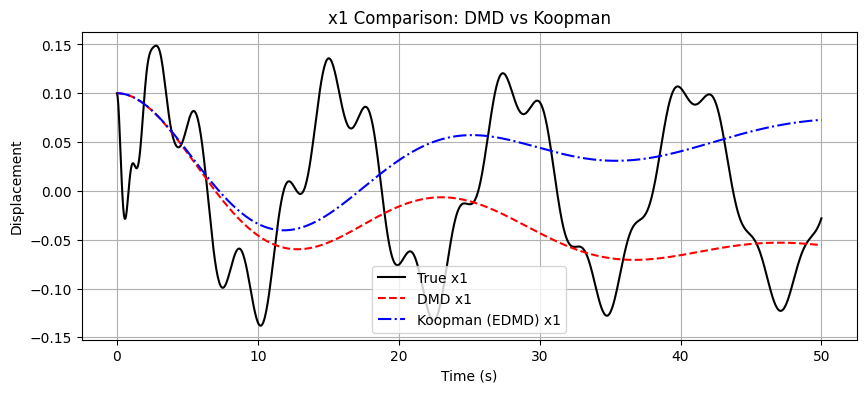

In [7]:
# Compare DMD vs EDMD (Koopman) vs True
plt.figure(figsize=(10, 4))
plt.plot(t_eval, X[0], 'k', label='True x1')
plt.plot(t_eval, X_dmd[0].real, 'r--', label='DMD x1')
plt.plot(t_eval, X_edmd[0].real, 'b-.', label='Koopman (EDMD) x1')
plt.title('x1 Comparison: DMD vs Koopman')
plt.xlabel('Time (s)')
plt.ylabel('Displacement')
plt.legend()
plt.grid(True)
plt.show()

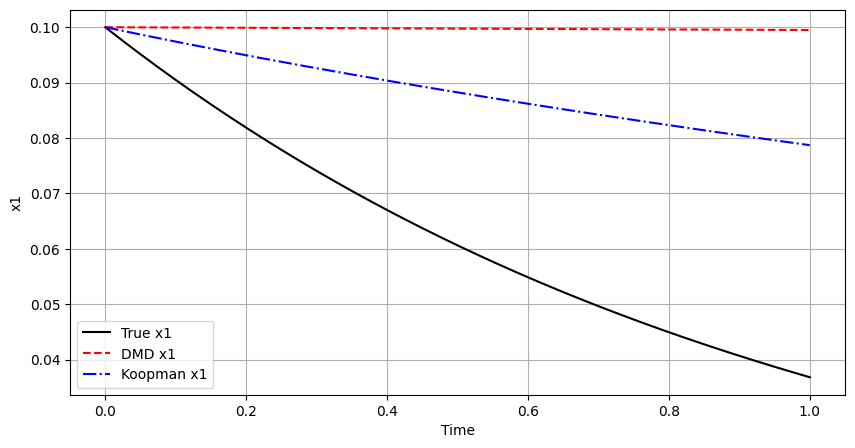

DMD rel error: 0.6192
Koopman rel error: 0.4272
DMD eigs: [1.00505069 0.99497613]
Koopman eigs: [0.23287067 0.61626237 0.84808137 0.98600483 0.98810603 0.90374587
 0.95265905]


In [26]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from numpy.linalg import svd, pinv, eig

# System parameters
rho, zeta = -1.0, 1.0

def f(t, x):
    x1, x2 = x
    return [rho * x1, zeta * (x2 - x1**2)]

def lift(x):
    x1, x2 = x
    return np.array([x1, x2,
                     x1**2, x2**2,
                     x1*x2,
                     x1**3, x2**3])

def simulate_trajectory(x0, t):
    sol = spi.solve_ivp(f, [t[0], t[-1]], x0, t_eval=t)
    X = sol.y
    Y = np.vstack([lift(sol.y[:,i]) for i in range(sol.y.shape[1])]).T
    return X, Y

def compute_edmd(Y, r):
    Y1, Y2 = Y[:,:-1], Y[:,1:]
    U, S, Vh = svd(Y1, full_matrices=False)
    Ur, Sr, Vr = U[:,:r], np.diag(S[:r]), Vh.conj().T[:,:r]
    A_tilde = Ur.T @ Y2 @ Vr @ pinv(Sr)
    eigvals, W = eig(A_tilde)
    Phi = Y2 @ Vr @ pinv(Sr) @ W
    return eigvals, Phi

def predict(Phi, eigvals, y0, t):
    b = pinv(Phi) @ y0
    omega = np.log(eigvals)
    time_dyn = np.array([b * np.exp(omega * ti) for ti in t]).T
    Y_pred = Phi @ time_dyn
    return Y_pred

def compute_dmd(X, r):
    X1, X2 = X[:,:-1], X[:,1:]
    U, S, Vh = svd(X1, full_matrices=False)
    Ud, Sd, Vd = U[:,:r], np.diag(S[:r]), Vh.conj().T[:,:r]
    A_dmd = Ud.T @ X2 @ Vd @ pinv(Sd)
    eigvals, W = eig(A_dmd)
    Phi = X2 @ Vd @ pinv(Sd) @ W
    return eigvals, Phi

def main():
    # Simulation setup
    T = 1.0
    t = np.linspace(0, T, 200)
    # Generate training data
    M = 50
    Y_all = []
    for x0 in np.random.uniform(-0.9, 0.9, (M,2)):
        _, Y = simulate_trajectory(x0, t)
        Y += 0.1 * np.random.randn(*Y.shape)
        Y_all.append(Y)
    Y_train = np.hstack(Y_all)
    # EDMD training
    r_edmd = 10
    eig_k, Phi_k = compute_edmd(Y_train, r_edmd)
    # Test trajectory
    x0_test = np.array([0.1, 0.5])
    X_true, Y_test = simulate_trajectory(x0_test, t)
    y0 = lift(x0_test)
    Y_kpred = predict(Phi_k, eig_k, y0, t)
    # DMD on original states
    eig_d, Phi_d = compute_dmd(X_true, r=5)
    X_dpred = predict(Phi_d, eig_d, X_true[:,0], t)
    # Plot results
    plt.figure(figsize=(10,5))
    plt.plot(t, X_true[0], 'k', label='True x1')
    plt.plot(t, X_dpred[0].real, 'r--', label='DMD x1')
    plt.plot(t, Y_kpred[0].real, 'b-.', label='Koopman x1')
    plt.xlabel('Time')
    plt.ylabel('x1')
    plt.legend()
    plt.grid(True)
    plt.show()
    # Error metrics
    err_d = np.linalg.norm(X_true[0] - X_dpred[0].real)/np.linalg.norm(X_true[0])
    err_k = np.linalg.norm(X_true[0] - Y_kpred[0].real)/np.linalg.norm(X_true[0])
    print(f"DMD rel error: {err_d:.4f}")
    print(f"Koopman rel error: {err_k:.4f}")
    # Eigenvalues
    print("DMD eigs:", eig_d)
    print("Koopman eigs:", eig_k)

if __name__ == '__main__':
    main()